In [64]:
import numpy as np
import pandas as pd
import itertools
import random
import string
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy



# RAF

### Pre-processing

In [112]:
# This function is INCORRECT

def create_rxn_network (n, num_reactions, food_size, c_p = 0.25, reactants =2, k = 2):
    # Set of Molecules
    X = [''.join(i) for i in itertools.product(string.ascii_uppercase, repeat=k)][0:n]

    # Food (subset of molecules)
    #food_size = int(f_p*n)
    F = random.sample(X, food_size)

    # Reaction (pair of molecules)
    #num_reactions = int(r_p * n)
    R = {}
    for i in range(num_reactions):
        x= random.sample(X, 1)[0]
        react = random.sample(X, reactants)
        while x in react:
            x= random.sample(X, 1)[0]
        R[i] = [react, x]


    #no self-catalyzing
    # Duplicates in dictionary

    num_catal = int(c_p * n)

    C = {}
    for i in range(num_reactions):
        for j in X:
            if  np.random.random(1)[0]< c_p:
                if j in C.keys():
                    C[j].append(i)
                else:
                    C[j]= [i]
    
    return (X, F, R, C)

In [51]:
def create_kauffman_network (n, t, p, k = 2):
    # Set of Molecules
    X = []
    F = []
    alphabet = string.ascii_uppercase[0:k]
    for i in range(1, n+1):    
        vals = [''.join(m) for m in itertools.product(alphabet, repeat=i)]
        X = X + vals
        if i <= t:
            F = F + vals
    #print(X)
    #print(F)

    # Reaction (pair of molecules)
    R = {}
    react_count = 1
    for i in range(len(X)):
        cand = X[i] + X[i]
        if len(cand) <= n:
            R[react_count] = [[X[i], X[i]], [cand]]
            react_count +=1
            #Lysis Reaction
            R[react_count] = [[cand],[X[i], X[i]]]
            react_count +=1

        for j in range(i+1, len(X)):
            cand1 = X[i] + X[j]
            cand2 = X[j] + X[i]
            if len(cand1) <= n:
                #Addition Reaction
                R[react_count] = [[X[i], X[j]], [cand1]]
                react_count +=1
                R[react_count] = [[X[j], X[i]], [cand2]]
                react_count +=1

                #Lysis Reaction
                R[react_count] = [[cand1],[X[i], X[j]]]
                react_count +=1
                R[react_count] = [[cand2],[X[j], X[i]]]
                react_count +=1

    #print(R)



    C = {}
    for i in X:
        for j in range(react_count):
            if np.random.random(1)[0] < p:
                if j in C.keys():
                    C[j].append(i)
                else:
                    C[j]= [i]

    return (X, F, R, C)

In [52]:
create_kauffman_network(2,1,1)

(['A', 'B', 'AA', 'AB', 'BA', 'BB'],
 ['A', 'B'],
 {1: [['A', 'A'], ['AA']],
  2: [['AA'], ['A', 'A']],
  3: [['A', 'B'], ['AB']],
  4: [['B', 'A'], ['BA']],
  5: [['AB'], ['A', 'B']],
  6: [['BA'], ['B', 'A']],
  7: [['B', 'B'], ['BB']],
  8: [['BB'], ['B', 'B']]},
 {0: ['A', 'B', 'AA', 'AB', 'BA', 'BB'],
  1: ['A', 'B', 'AA', 'AB', 'BA', 'BB'],
  2: ['A', 'B', 'AA', 'AB', 'BA', 'BB'],
  3: ['A', 'B', 'AA', 'AB', 'BA', 'BB'],
  4: ['A', 'B', 'AA', 'AB', 'BA', 'BB'],
  5: ['A', 'B', 'AA', 'AB', 'BA', 'BB'],
  6: ['A', 'B', 'AA', 'AB', 'BA', 'BB'],
  7: ['A', 'B', 'AA', 'AB', 'BA', 'BB'],
  8: ['A', 'B', 'AA', 'AB', 'BA', 'BB']})

In [174]:
def graph (X, F, R, C):
    DG = nx.DiGraph()

    for node in X:
   
        if node in F:
            DG.add_node(node, ncolor = "orange")
           
        else:
            DG.add_node(node, ncolor = 'lawngreen')
        

    for node in R: 
        text = "R{}".format(node)
        DG.add_node(text, ncolor = 'salmon')
    

        for i in range(len(R[node][0])):
            DG.add_edge(R[node][0][i], text, weight = -1)
        
        for i in range(len(R[node][1])):
            DG.add_edge(text,R[node][1][i], weight = -1)
  

    for j in C:
        for k in C[j]:
            if k in X and j in list(R.keys()):
                text = "R{}".format(j)
                DG.add_edge(k, text, weight = 1)


    for edge in DG.edges(data=True):
        weight = edge[2]["weight"]

        if weight > 0:
            color = "fuchsia"
        elif weight < 0:
            color = "steelblue"
        edge[2]["color"] = color
        
    

    edge_colors = [DG[u][v]['color'] for u,v in DG.edges()]
    
    node_colors = list(nx.get_node_attributes(DG, "ncolor").values())
 


    nx.draw(DG, node_color= node_colors, edge_color = edge_colors, with_labels=True, font_weight='bold', node_size = 750, pos=nx.circular_layout(DG), connectionstyle='arc3, rad = 0.1')
    
    plt.show()

In [211]:
X,F,R,C = create_kauffman_network(3,1,0.2)
print(len(X))
print(len(R))

14
40


In [ ]:
X

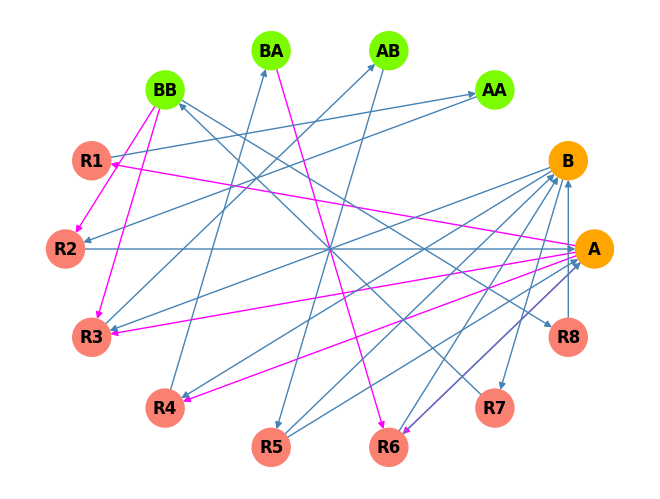

In [59]:
graph(X,F,R,C)

### RAF Algorithm

In [73]:
# Find all possible molecules able to be produced by the food set and available reactions

def closure(F, R):
    no_change = 0
    X = list(F)

    while no_change !=1:
        no_change = 1

        for i in list(R.values()):
            sufficient = 1
            for j in i[0]:
                if j not in X:
                    sufficient = 0
            if sufficient == 1:
                for k in i[1]:
                    if k not in X:
                        X.append(k)
                        no_change = 0
    return(X)
            


In [74]:
def Rsupp (R):
    supp = []
    for i in list(R.values()):
        cands = i[0] + i[1]
        for j in cands:
            if j not in supp:
                supp.append(j)
    return(supp)


In [144]:
# Applies R1: Remove all reactions that are not catalyzed by a molecule involved in our system



def reduceR(R, C):
    # no_change = 0
    # catalyzed = [element for sublist in list(C.values()) for element in sublist]
    # uncat_R = list(set(R.keys()) - set(catalyzed))

    # for i in uncat_R:
    #     del R[i]

    # catalysts = list(C.keys())
    # while no_change != 1:
    #     R_supp = Rsupp(R)
 
    #     no_change =1

    #     for i in catalysts:
    #         if i not in R_supp:
    #             #remove reaction
    #             for k in C[i]:
    #                 if k in R.keys():
    #                     del R[k]
    #                     no_change = 0

    catalyzed = list(C.keys())
    uncat_R = list(set(R.keys()) - set(catalyzed))


    for i in uncat_R:
        del R[i]
    
    
    no_change = 0
    while no_change != 1:
        no_change = 1

        suppR= Rsupp(R)
        Rs = list(C.keys())

        # print(C)
        # print(Rs)
        for i in Rs:
            for j in C[i]:
                if j not in suppR:
                    C[i] = C[i].remove(j)
                
                if not C[i]:
                    # print("DELETE")
                    del C[i]
                    if i in R:
                        del R[i]
                    no_change = 0
                    break
         
    return(R,C)
            

In [76]:
def reduceToF(F, R):
    W = closure(F,R)
    r_num= list(R.keys())
    
    for i in r_num:
        remove = 0
        for j in R[i][0]:
            if j not in W:
                remove = 1
                break
        if remove == 1:
            del R[i]

    
    return R

In [193]:
def RAF_pictoral(X,F,R,C):
    X_old = X.copy()
    R_old = copy.deepcopy(R)
    print("Initial")
    graph(X, F, R, C)

    i = 0 
    change = 0
    while change != 1:
        R, C = reduceR(R, C)
        # print("ReduceR")
        # print(R)
        # print(C)

        X = closure(F,R)

        # print("Closure")
        # print(X)
        R = reduceToF(F,R)

        # print("ReduceToF")
        # print(R)

        i= i+1

        if R != False and X != False:

            print("Round {}".format(i))
            # print(X)
            # print(R)
            # print(C)
            # print("---")
            # print(X_old)
            # print(R_old)
            # print("")
        


            graph(X, F, R, C)
            # print(X_old)
            # print(X)
            # print("----")
            # print(R_old)
            # print(R)
            if X_old == X and R_old == R:
                change = 1
            else:
                R_old = copy.deepcopy(R)
                X_old = X.copy()
        else:
            break

    

In [247]:
def RAF(X,F,R,C):
    X_old = X.copy()
    R_old = copy.deepcopy(R)

    i = 0 
    change = 0
    while change != 1:
        R, C = reduceR(R, C)
        X = closure(F,R)
        R = reduceToF(F,R)
        i= i+1

        if R != False and X != False:
            if X_old == X and R_old == R:
                change = 1
            else:
                R_old = copy.deepcopy(R)
                X_old = X.copy()
        else:
            break
    
    if not R:
        return 0
    else:
        return 1
    

# Examples

## Random Network (deprecated)

In [61]:
X, F, R, C = create_rxn_network (n=10, num_reactions = 40, food_size = 5 , c_p = 0.25, reactants =2)

NameError: name 'create_rxn_network' is not defined

Initial


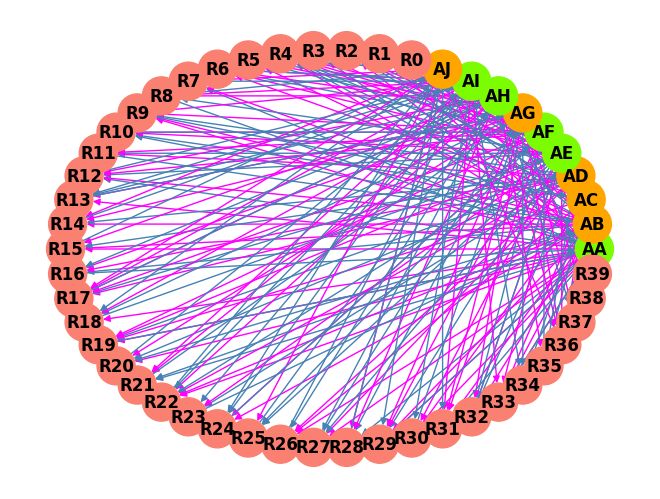

Round 1


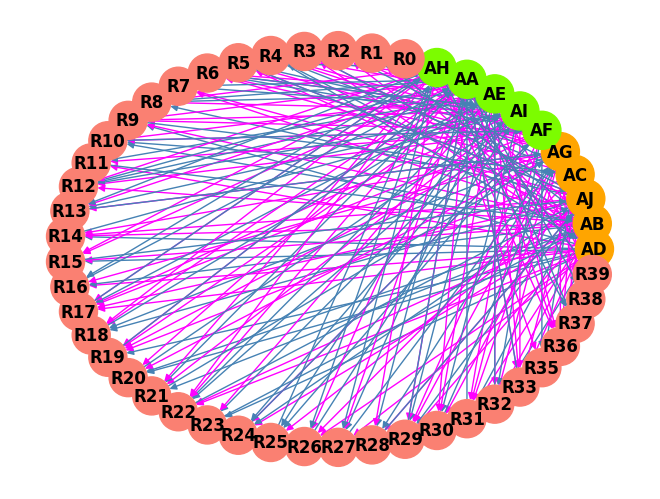

Round 2


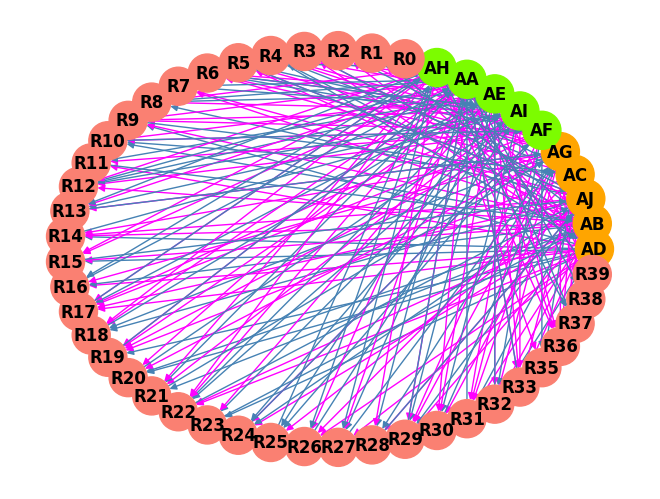

In [143]:
RAF_pictoral(X, F, R, C)

## Hordjik04 Example

In [252]:
X = [''.join(i) for i in itertools.product(string.ascii_uppercase, repeat=2)][0:7]
R = {1: [["AA", "AB"], ["AC"]],
    2: [["AB", "AC"], ["AD"]],
    3: [["AC", "AD"], ["AE", "AF"]],
    4: [["AA", "AE"], ["AG"]],
 }
F = ["AA", "AB"]
C = { 1:["AD"], 2:["AA"], 4:["AF"] }

Initial


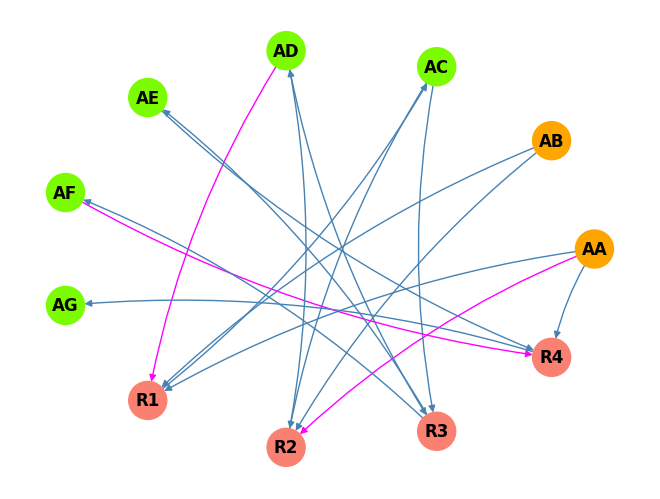

Round 1


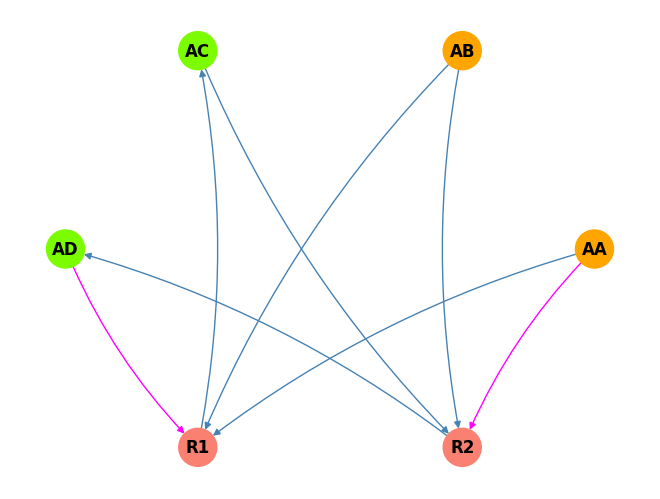

Round 2


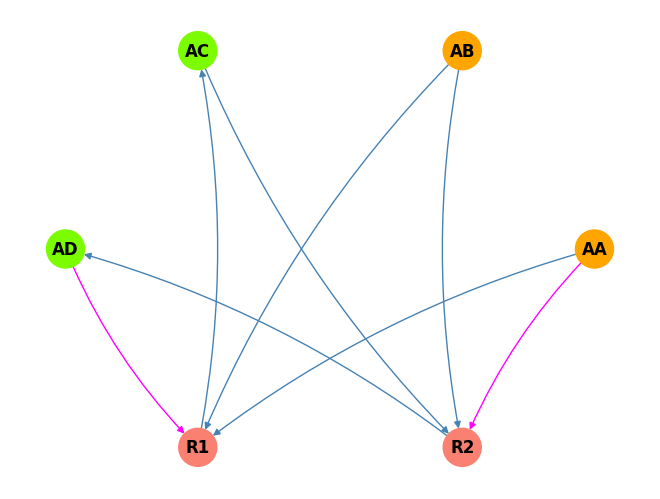

In [253]:
RAF_pictoral(X, F, R,C)

In [251]:
RAF(X,F,R,C)

0

## Kauffman Model

In [265]:
X,F,R,C = create_kauffman_network(3,1,0.05)

In [266]:
RAF(X,F,R,C)

1

Initial


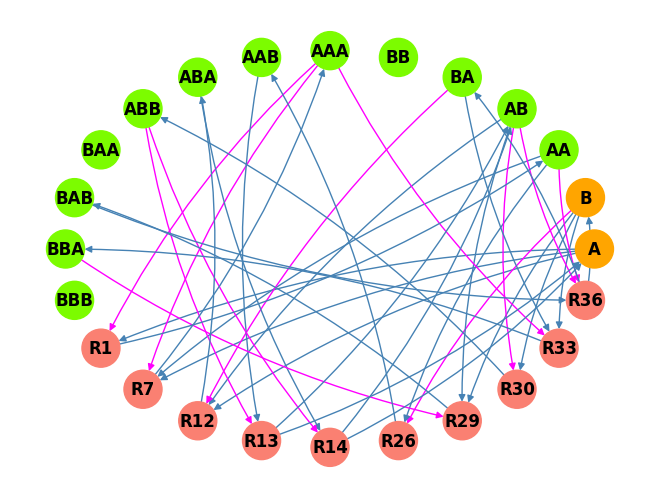

Round 1


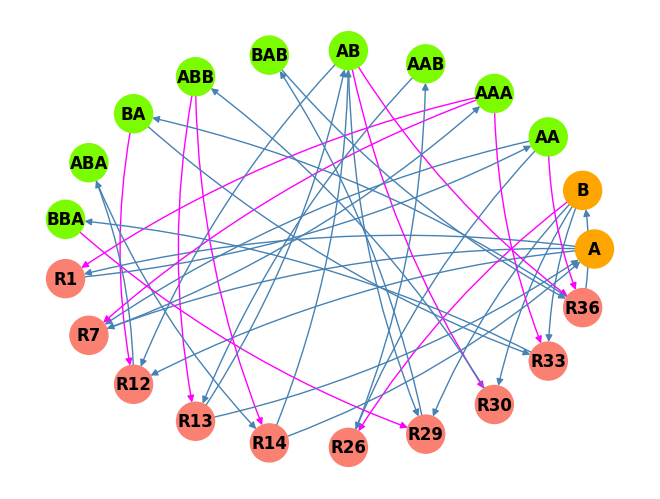

Round 2


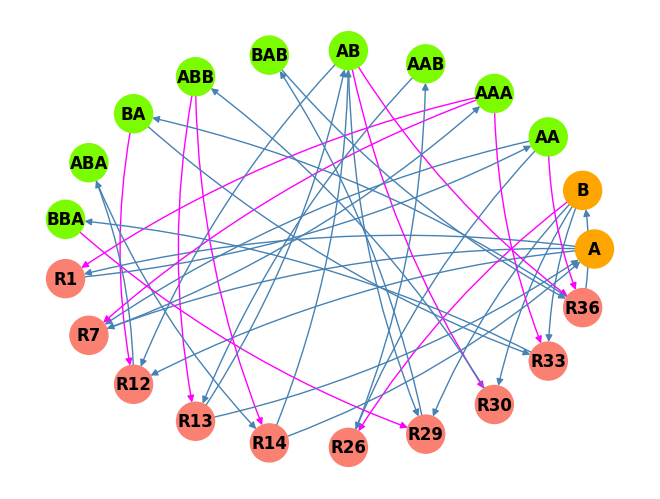

In [267]:
RAF_pictoral(X,F,R,C)

# Hordjik04 Simulation

In [274]:
def RAF_sim(Ns, ns, t, f_max, reps=50):
    plt.figure(figsize=(8,8))
    for i in range(len(ns)):
        X,F,R,C = create_kauffman_network(ns[i], 0, 0)
        R_size = len(R)
        p_max = f_max/R_size
        ps = np.linspace(0,p_max, reps)
        Xs = []
        Ys= []
        for p in ps:
            raf_count = 0
            for k in range(Ns[i]):
                X,F,R,C = create_kauffman_network(ns[i], t, p)
                raf_count = RAF(X,F,R,C) + raf_count

            Xs.append(p*R_size)
            Ys.append(raf_count/Ns[i])
        
        plt.plot(Xs,Ys, "-o", label= "n = {}".format(ns[i]))

    plt.legend()
    plt.xlabel("Expected Number of Catalysts")
    plt.ylabel("Probability of RAF Set")
    plt.title("Hordjik04 Probability Simulation")
    plt.show()




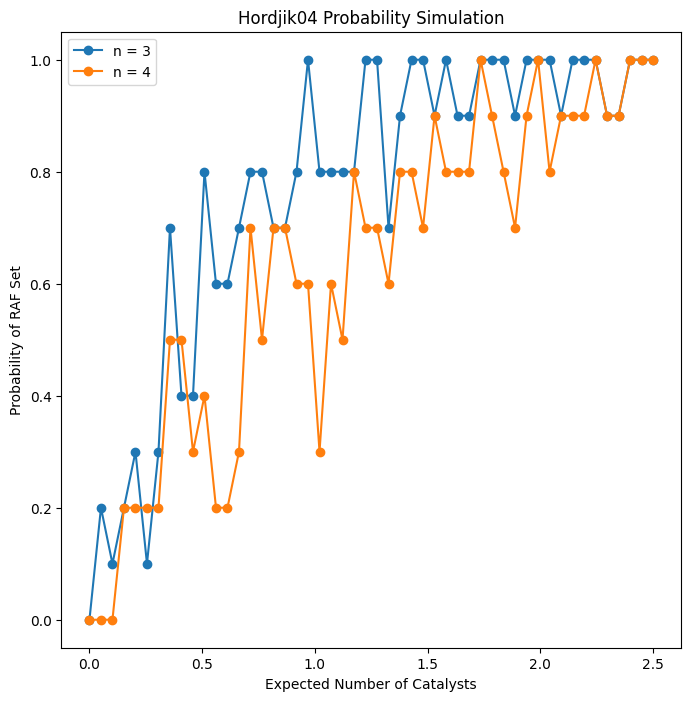

In [275]:
RAF_sim([10,10], [3,4], 2, 2.5)